In [1]:
from matplotlib import pyplot as plt
import jax.numpy as np
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as onp
from scipy.linalg import expm
from jax import jit, grad, value_and_grad, vmap
#from time import time
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.aer.pulse_new.de.DE_Problems import BMDE_Problem
from qiskit.providers.aer.pulse_new.de.DE_Solvers import BMDE_Solver
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.models.signals import VectorSignal, Constant, Signal
from qiskit.providers.aer.pulse_new.models.operator_models import OperatorModel

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 1. Check that basic model set up works

Changes I had to make to get this to work:
- Changed all `numpy` imports to `jax.numpy` in all files
- Changed one `if` statement due to a minor change in `jax` with the way arrays are compared
- Re-added an import of standard `numpy` in one file, to convert `jax` arrays to `numpy` arrays when used to instantiate an `Operator` (`jax` arrays are not accepted)

In [2]:
w = 5.
r = 0.02

signals = [Constant(1.), Signal(1., w)]
operators = [-1j * 2 * np.pi * w * Z / 2, -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(signals=signals, operators=operators)

/opt/anaconda3/envs/devEnv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
generator.evaluate(1.)

DeviceArray([[0.-15.70796327j, 0. -0.06283185j],
             [0. -0.06283185j, 0.+15.70796327j]], dtype=complex128)

Expected value:

In [4]:
gen_at_1 = -1j * 2 * np.pi * w * Z / 2 + onp.cos(2 * np.pi * w * 1.) *(-1j * 2 * np.pi * r * X / 2)
print(gen_at_1)

Operator([[0.-15.70796327j, 0. -0.06283185j],
          [0. -0.06283185j, 0.+15.70796327j]],
         input_dims=(2,), output_dims=(2,))


Enter frame and evaluate:

In [5]:
generator.frame = generator.drift

In [6]:
generator.evaluate(1.)

DeviceArray([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
             [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]],            dtype=complex128)

Expected value:

In [7]:
F = (-1j * 2 * np.pi * w * Z / 2).data
expm(-F) @ gen_at_1.data @ expm(F) - F

array([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
       [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]])

# 2. `jit`-ing

First `jit` and measure time of first evaluation

In [8]:
fast_evaluate = jit(lambda t: generator.evaluate(t))

%time fast_evaluate(1.).block_until_ready()

CPU times: user 337 ms, sys: 67.5 ms, total: 404 ms
Wall time: 51.2 ms


DeviceArray([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
             [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]],            dtype=complex128)

Now evaluate compare speed of `jit`ed function and non-`jit`ed

In [9]:
t = 1.

%time res1 = generator.evaluate(t).block_until_ready()

%time res2 = fast_evaluate(t).block_until_ready()

print(res1 - res2)

CPU times: user 19.3 ms, sys: 11.7 ms, total: 31 ms
Wall time: 3.83 ms
CPU times: user 3.25 ms, sys: 1.89 ms, total: 5.14 ms
Wall time: 684 µs
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


# 3. Trying jax solver

In [10]:
from jax.experimental.ode import odeint
from scipy.integrate import solve_ivp

In [11]:
regular_rhs = lambda y, t: generator.lmult(t, y)
fast_rhs = jit(regular_rhs)

In [12]:
%time odeint(func=fast_rhs, y0=np.array([1., 0.], dtype=complex), t=np.array([0., 2./r]), atol=1e-8, rtol=1e-8).block_until_ready()

CPU times: user 976 ms, sys: 37.1 ms, total: 1.01 s
Wall time: 902 ms


DeviceArray([[ 1.00000000e+00+0.00000000e+00j,
               0.00000000e+00+0.00000000e+00j],
             [-1.00000012e+00-1.17843091e-11j,
              -5.51258751e-09-3.48955056e-07j]], dtype=complex128)

In [13]:
def full_int(rhs, t_val):
    return odeint(func=rhs, y0=np.array([1., 0.], dtype=complex), t=np.array([0., t_val]))

In [14]:
#jit_int = jit(full_int)

In [15]:
%time full_int(regular_rhs, 0.5 / r).block_until_ready()

CPU times: user 805 ms, sys: 11.5 ms, total: 817 ms
Wall time: 807 ms


DeviceArray([[ 1.00000000e+00+0.00000000e+00j,
               0.00000000e+00+0.00000000e+00j],
             [ 7.07106933e-01+3.53497031e-04j,
              -2.10677721e-08-7.07106597e-01j]], dtype=complex128)

In [96]:
rhs = jit(generator.lmult)
rhs(0.1, np.array([1, 0])) # avoid measuring time of compilation
%time results = solve_ivp(rhs, (0., 1. / r), y0=onp.array([1., 0.], dtype=complex), method='RK45', atol=1e-10, rtol=1e-10)
results.y[:, 1]

CPU times: user 8.9 s, sys: 1.36 s, total: 10.3 s
Wall time: 8.13 s


array([ 9.99999952e-01-2.49337333e-09j, -2.40556854e-05-3.08949712e-04j])

# 4. Does it differentiate

In [17]:
def param_sim(params):
    t = params
    c = 1.
    gen_copy = generator.copy()
    gen_copy.signals = [Constant(1.), Signal(lambda t: c, w)]
    return np.abs(odeint(func=lambda y, t: gen_copy.lmult(t, y), y0=np.array([1., 0.], dtype=complex), t=np.array([0., t]),atol=1e-8, rtol=1e-8)[-1][1])**2

In [18]:
# just time
#time_param_sim = lambda t: param_sim(np.array([1., t], dtype=complex))

In [19]:
grad_test = jit(value_and_grad(param_sim))

In [20]:
%time grad_test(1./r)[1].block_until_ready()

CPU times: user 1.85 s, sys: 28.5 ms, total: 1.88 s
Wall time: 1.85 s


DeviceArray(2.70190449e-08, dtype=float64)

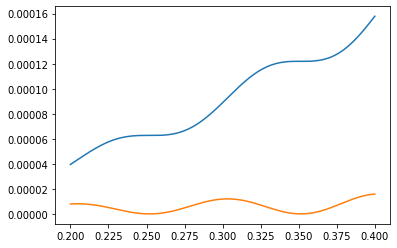

In [21]:
t_vals = np.linspace(0.2, 0.4, 1000)
#vals = vmap(grad_test)(t_vals)
#func_vals = vals[0]
#grad_vals = vals[1]
vals = [grad_test(t) for t in t_vals]
func_vals = np.array([entry[0] for entry in vals])
grad_vals = np.array([entry[1] for entry in vals])
plt.plot(t_vals, func_vals)
plt.plot(t_vals, grad_vals*0.01)

# 5. Trying with solvers

In [37]:
de_problem = BMDE_Problem(generator=generator, 
                          y0=np.array([1., 0.], dtype=complex),
                          t0=0.)
options = DE_Options(atol=1e-8, rtol=1e-8)
solver = BMDE_Solver(de_problem, options=options)

In [32]:
%time solver.integrate(1./r)

CPU times: user 857 ms, sys: 8.6 ms, total: 866 ms
Wall time: 853 ms


In [34]:
solver.y @ solver.y.conj().transpose()

DeviceArray([[1.00000012+0.j, 0.        +0.j],
             [0.        +0.j, 1.00000012+0.j]], dtype=complex128)

In [108]:
def full_sim(t):
    gen_copy = generator.copy()
    import pdb; pdb.set_trace()
    de_problem = BMDE_Problem(generator=gen_copy, 
                          y0=np.array([1., 0.], dtype=complex),
                          t0=0.,
                          cutoff_freq=2*w)
    options = DE_Options(atol=1e-10, rtol=1e-10)
    solver = BMDE_Solver(de_problem, options=options)
    solver.integrate(t)
    return np.abs(solver.y[1])**2

In [106]:
jit_full_sim = jit(full_sim)
jit_grad_full_sim = jit(value_and_grad(full_sim))

In [107]:
%time jit_grad_full_sim(4./r)[0].block_until_ready()

AttributeError: 'NoneType' object has no attribute 'drift_array'

In [109]:
%time full_sim(1./r)

> <ipython-input-108-17617cdd588b>(4)full_sim()
      2     gen_copy = generator.copy()
      3     import pdb; pdb.set_trace()
----> 4     de_problem = BMDE_Problem(generator=gen_copy, 
      5                           y0=np.array([1., 0.], dtype=complex),
      6                           t0=0.,

ipdb> gen_copy.drift
*** AttributeError: 'NoneType' object has no attribute 'drift_array'
ipdb> c


AttributeError: 'NoneType' object has no attribute 'drift_array'

# 6. Optimizing continuous pulses with variable integration length

In [104]:
w = 5.
r = 0.02

operators = [-1j * 2 * np.pi * w * Z / 2, -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(operators=operators)

Exception: OperatorModel cannot be
                               evaluated without signals.